In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
from tensorflow import keras
import qkeras
from tensorflow.keras.callbacks import ModelCheckpoint
import datetime
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
#import plotting
%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

os.environ['PATH'] = '/home/ypmen/Data/Xilinx/Vitis_HLS/2022.2/bin:' + os.environ['PATH']

2024-09-04 19:12:00.361230: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [3]:
# Normalize pixel values to be between 0 and 1
train_images = (train_images) / 255.0
test_images = (test_images) / 255.0

train_images = train_images.reshape(train_images.shape[0], train_images.shape[1], train_images.shape[2], 1)
test_images = test_images.reshape(test_images.shape[0], test_images.shape[1], test_images.shape[2], 1)

In [4]:
from tensorflow.keras.layers import *
from qkeras import *
# Define the model architecture
model = keras.Sequential([
	QActivation(activation=quantized_bits(8, 2), input_shape=(28, 28, 1)),
    QConv2D(8, 3, activation=quantized_bits(8, 2), kernel_quantizer=quantized_bits(8,2,alpha=1), bias_quantizer=quantized_bits(8,2,alpha=1), kernel_initializer='lecun_uniform'),
	QActivation(activation=quantized_relu(8, 2)),
    QBatchNormalization(beta_quantizer=quantized_bits(32, 8), gamma_quantizer=quantized_bits(32, 8), mean_quantizer=quantized_bits(32, 8), variance_quantizer=quantized_bits(32, 8)),
    QActivation(activation=quantized_bits(8, 2)),
	MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    QConv2D(8, 3, activation=quantized_bits(8, 2), kernel_quantizer=quantized_bits(8,2,alpha=1), bias_quantizer=quantized_bits(8,2,alpha=1), kernel_initializer='lecun_uniform'),
	QActivation(activation=quantized_relu(8, 2)),
    QBatchNormalization(beta_quantizer=quantized_bits(32, 8), gamma_quantizer=quantized_bits(32, 8), mean_quantizer=quantized_bits(32, 8), variance_quantizer=quantized_bits(32, 8)),
    QActivation(activation=quantized_bits(8, 2)),
	MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
	Flatten(),
   	QDense(10, kernel_quantizer=quantized_bits(8,2,alpha=1), bias_quantizer=quantized_bits(8,2,alpha=1), kernel_initializer='lecun_uniform'),
    Softmax()
])

model.summary()

2024-09-04 19:12:03.051490: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-09-04 19:12:03.051515: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: Moon
2024-09-04 19:12:03.051521: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: Moon
2024-09-04 19:12:03.051600: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.89.2
2024-09-04 19:12:03.051617: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.89.2
2024-09-04 19:12:03.051622: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 525.89.2
2024-09-04 19:12:03.051852: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neu

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_activation (QActivation)  (None, 28, 28, 1)         0         
                                                                 
 q_conv2d (QConv2D)          (None, 26, 26, 8)         80        
                                                                 
 q_activation_1 (QActivation  (None, 26, 26, 8)        0         
 )                                                               
                                                                 
 q_batch_normalization (QBat  (None, 26, 26, 8)        32        
 chNormalization)                                                
                                                     

## Introduction
This is a tutorial to introduce how to transform Keras ML model to vitis hls code. In this tutorial, you will learn how to use quantized aware training (QAT) and model pruning with QKeras. Moreover, you will learn how the model is transformed to Vitis HLS code in the HLS4ML framework. The tutorial is shown using an example of mnist.

In [5]:
# Compile the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# callbacks
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint = ModelCheckpoint('chechpoint/test.h5', monitor='val_loss', save_best_only=True)

In [6]:
# Train the model
model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels), callbacks=[tensorboard_callback, checkpoint])

Epoch 1/10


2024-09-04 19:12:06.352794: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.
/home/ypmen/Data/software/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1875/1875 [==============================] - 21s 9ms/step - loss: 0.2804 - accuracy: 0.9146 - val_loss: 0.1099 - val_accuracy: 0.9674
Epoch 2/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0976 - accuracy: 0.9696 - val_loss: 0.0811 - val_accuracy: 0.9737
Epoch 3/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0841 - accuracy: 0.9729 - val_loss: 0.0721 - val_accuracy: 0.9769
Epoch 4/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0790 - accuracy: 0.9747 - val_loss: 0.0866 - val_accuracy: 0.9723
Epoch 5/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0802 - accuracy: 0.9744 - val_loss: 0.1041 - val_accuracy: 0.9656
Epoch 6/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0865 - accuracy: 0.9725 - val_loss: 0.0953 - val_accuracy: 0.9683
Epoch 7/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0884 - accuracy: 0.9724 - val_loss: 0.1093 - val_accuracy

In [7]:
model.save('mnist.h5')
#model = qkeras.utils.load_qmodel('mnist.h5')

In [8]:
import tensorflow_model_optimization as tfmot

pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, 0),
    'block_size': (1, 1),
    'block_pooling_type': 'AVG'
}

def apply_pruning(layer):
  if isinstance(layer, QDense):
    return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
  elif isinstance(layer, QConv2D):
    return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
  return layer

model_for_pruning = tf.keras.models.clone_model(
    model,
    clone_function=apply_pruning,
)

callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    # Log sparsity and other metrics in Tensorboard.
    tfmot.sparsity.keras.PruningSummaries(log_dir=log_dir)
]

model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_activation (QActivation)  (None, 28, 28, 1)         0         
                                                                 
 prune_low_magnitude_q_conv2  (None, 26, 26, 8)        154       
 d (PruneLowMagnitude)                                           
                                                                 
 q_activation_1 (QActivation  (None, 26, 26, 8)        0         
 )                                                               
                                                                 
 q_batch_normalization (QBat  (None, 26, 26, 8)        32        
 chNormalization)                                                
                                                                 
 q_activation_2 (QActivation  (None, 26, 26, 8)        0         
 )                                                      

In [9]:
# Train the model
model_for_pruning.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels), callbacks=callbacks)

Epoch 1/10


2024-09-04 19:15:20.620977: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 [==============================] - 24s 11ms/step - loss: 0.1400 - accuracy: 0.9554 - val_loss: 0.1807 - val_accuracy: 0.9438
Epoch 2/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.1474 - accuracy: 0.9528 - val_loss: 0.1476 - val_accuracy: 0.9536
Epoch 3/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.1574 - accuracy: 0.9501 - val_loss: 0.1560 - val_accuracy: 0.9516
Epoch 4/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1781 - accuracy: 0.9433 - val_loss: 0.1796 - val_accuracy: 0.9451
Epoch 5/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2162 - accuracy: 0.9307 - val_loss: 0.2563 - val_accuracy: 0.9190
Epoch 6/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.2479 - accuracy: 0.9207 - val_loss: 0.2496 - val_accuracy: 0.9225
Epoch 7/10
1875/1875 [==============================] - 31s 16ms/step - loss: 0.2671 - accuracy: 0.9142 - val_loss: 0.2375 - val_accuracy

In [10]:
# Evaluate the model

from sklearn.metrics import classification_report

#model = qkeras.utils.load_qmodel('mnist.h5')

pred = model.predict(test_images)
predicted = np.argmax(pred, axis=1)
report = classification_report(test_labels, predicted)

print(report)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

313/313 [==============================] - 2s 5ms/step
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       980
           1       0.93      0.95      0.94      1135
           2       0.87      0.86      0.87      1032
           3       0.89      0.81      0.85      1010
           4       0.82      0.88      0.85       982
           5       0.88      0.79      0.83       892
           6       0.87      0.90      0.89       958
           7       0.90      0.86      0.88      1028
           8       0.85      0.86      0.86       974
           9       0.84      0.86      0.85      1009

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

313/313 [==============================] - 1s 5ms/step - loss: 0.3883 - accuracy: 0.8732
Test accuracy: 0.873199999332428


In [11]:
# Evaluate the model

from sklearn.metrics import classification_report

pred = model_for_pruning.predict(test_images)
predicted = np.argmax(pred, axis=1)
report = classification_report(test_labels, predicted)

print(report)

test_loss, test_acc = model_for_pruning.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

313/313 [==============================] - 2s 5ms/step
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       980
           1       0.93      0.95      0.94      1135
           2       0.87      0.86      0.87      1032
           3       0.89      0.81      0.85      1010
           4       0.82      0.88      0.85       982
           5       0.88      0.79      0.83       892
           6       0.87      0.90      0.89       958
           7       0.90      0.86      0.88      1028
           8       0.85      0.86      0.86       974
           9       0.84      0.86      0.85      1009

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

313/313 [==============================] - 2s 5ms/step - loss: 0.3883 - accuracy: 0.8732
Test accuracy: 0.873199999332428


# HLS4ML

In [12]:
import hls4ml

import yaml

with open("config.yaml", 'r') as ymlfile:
	config = yaml.safe_load(ymlfile)

print("-----------------------------------")
print("Configuration")
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config,
                                                       output_dir='model_1/hls4ml_prj',
                                                       part='xcu55c-fsvh2892-2L-e',
                                                       io_type='io_stream',
                                                       backend='Vitis')

-----------------------------------
Configuration
-----------------------------------
Interpreting Sequential
Topology:
Layer name: q_activation_input, layer type: InputLayer, input shapes: [[None, 28, 28, 1]], output shape: [None, 28, 28, 1]
Layer name: q_activation, layer type: Activation, input shapes: [[None, 28, 28, 1]], output shape: [None, 28, 28, 1]
Layer name: q_conv2d, layer type: QConv2D, input shapes: [[None, 28, 28, 1]], output shape: [None, 26, 26, 8]
Layer name: q_activation_1, layer type: Activation, input shapes: [[None, 26, 26, 8]], output shape: [None, 26, 26, 8]
Layer name: q_batch_normalization, layer type: QBatchNormalization, input shapes: [[None, 26, 26, 8]], output shape: [None, 26, 26, 8]
Layer name: q_activation_2, layer type: Activation, input shapes: [[None, 26, 26, 8]], output shape: [None, 26, 26, 8]
Layer name: max_pooling2d, layer type: MaxPooling2D, input shapes: [[None, 26, 26, 8]], output shape: [None, 13, 13, 8]
Layer name: q_conv2d_1, layer type: Q

/home/ypmen/Data/software/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/hls4ml/converters/__init__.py:24: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


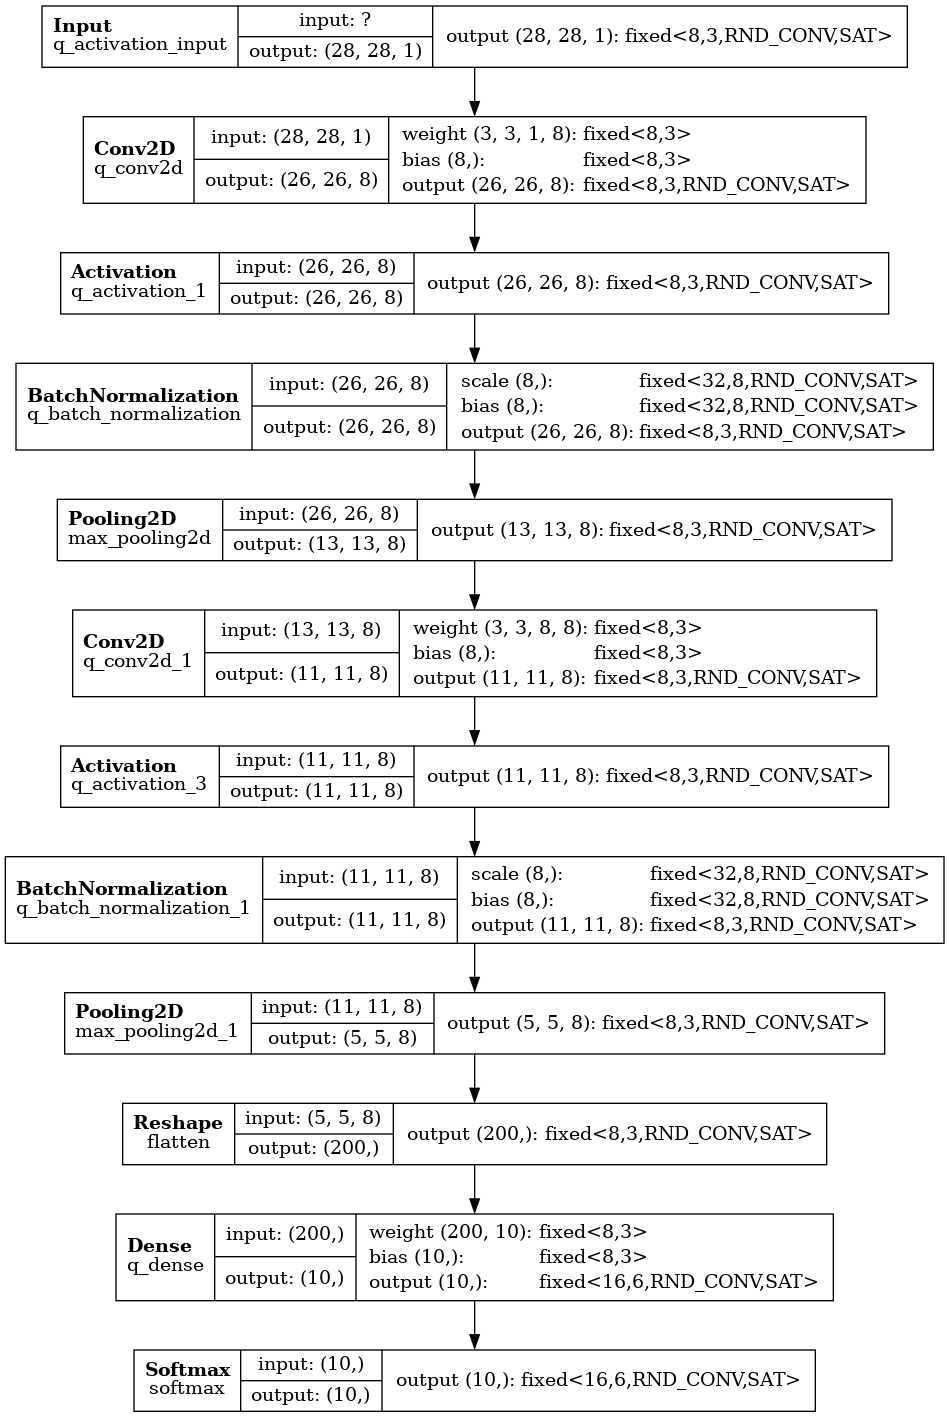

In [13]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

In [14]:
hls_model.compile()

Writing HLS project
Done


In [15]:
labels_keras = np.argmax(model.predict(test_images), 1)

313/313 [==============================] - 1s 4ms/step


In [16]:
labels_hls = np.argmax(hls_model.predict(test_images), 1)

In [10]:
from sklearn.metrics import accuracy_score

print("Keras  Accuracy: {}".format(accuracy_score(test_labels, labels_keras)))
print("hls4ml Accuracy: {}".format(accuracy_score(test_labels, labels_hls)))

Keras  Accuracy: 0.9775
hls4ml Accuracy: 0.977


In [13]:
hls_model.predict(np.round(test_images[0:2]*2**5)/2**5)

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

In [11]:
np.arange(len(labels_keras))[labels_keras != labels_hls]

array([ 326, 1033, 1553, 1903, 2387, 3599, 4078, 4494, 4690, 5201, 5642,
       7265, 7447, 7928, 8520, 9638, 9692, 9904])

In [26]:
hls_model.build(csim=False)

sh: /home/ypmen/Data/software/anaconda3/envs/ypmen-py38/lib/libtinfo.so.6: no version information available (required by sh)
sh: /home/ypmen/Data/software/anaconda3/envs/ypmen-py38/lib/libtinfo.so.6: no version information available (required by sh)
/bin/bash: /home/ypmen/Data/software/anaconda3/envs/ypmen-py38/lib/libtinfo.so.6: no version information available (required by /bin/bash)


/bin/bash: /home/ypmen/Data/software/anaconda3/envs/ypmen-py38/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/ypmen/Data/software/anaconda3/envs/ypmen-py38/lib/libtinfo.so.6: no version information available (required by /bin/bash)

****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2022.2 (64-bit)
  **** SW Build 3670227 on Oct 13 2022
  **** IP Build 3669848 on Fri Oct 14 08:30:02 MDT 2022
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.

source /home/ypmen/Data/Xilinx/Vitis_HLS/2022.2/scripts/vitis_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/home/ypmen/Data/Xilinx/Vitis_HLS/2022.2/bin/unwrapped/lnx64.o/vitis_hls'
INFO: [HLS 200-10] For user 'ypmen' on host 'Moon' (Linux_x86_64 version 5.4.0-59-generic) on Sun Sep 01 16:05:47 CEST 2024
INFO: [HLS 200-10] On os Ubuntu 18.04.4 LTS
INFO: [HLS 200-10] In directory '/home/ypmen/Data/vscode/AI/hls4ml/mnist/model_1/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
IN

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '11.392',
  'BestLatency': '3155',
  'WorstLatency': '3205',
  'IntervalMin': '3139',
  'IntervalMax': '3139',
  'BRAM_18K': '80',
  'DSP': '14',
  'FF': '18613',
  'LUT': '76567',
  'URAM': '0',
  'AvailableBRAM_18K': '5376',
  'AvailableDSP': '12288',
  'AvailableFF': '3456000',
  'AvailableLUT': '1728000',
  'AvailableURAM': '1280'}}

In [27]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj')

Found 1 solution(s) in model_1/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vitis HLS Report for 'myproject'
* Date:           Sun Sep  1 16:08:13 2024

* Version:        2022.2 (Build 3670227 on Oct 13 2022)
* Project:        myproject_prj
* Solution:       solution1 (Vivado IP Flow Target)
* Product family: virtexuplus
* Target device:  xcu250-figd2104-2L-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+-----------+------------+
    |  Clock |  Target | Estimated | Uncertainty|
    +--------+---------+-----------+------------+
    |ap_clk  |  5.00 ns|  11.392 ns|     0.62 ns|
    +--------+---------+-----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+-----------+-----------+------+------+----------+
    |  Latency (cycles) |   Latency (absolute)  |   Interval  | Pipeline |
    |   min   |   max   |    min    |    max    |  min |  max |   Type   |
    +-------

In [18]:
np.savetxt('model_1/hls4ml_prj/tb_data/tb_input_features.dat', (np.round(test_images[0]*2**5)/2**5).flatten())

In [15]:
np.savetxt('model_1/hls4ml_prj/tb_data/tb_output_predictions.dat', hls_model.predict(np.round(test_images[0:2]*2**5)/2**5)[0])

In [20]:
a = (np.round(test_images[0]*2**5)/2**5).flatten()

In [25]:
a[np.arange(len(a))[a != 0]]*32

array([11., 23., 20., 19.,  8.,  5., 28., 32., 32., 32., 32., 30., 25.,
       25., 25., 25., 25., 25., 25., 25., 21.,  7.,  8., 14.,  9., 14.,
       20., 28., 32., 28., 32., 32., 32., 31., 29., 32., 32., 18.,  2.,
        8.,  2.,  8.,  8.,  8.,  7.,  3., 30., 32., 13., 10., 32., 26.,
        2.,  3., 29., 32., 10., 16., 32., 30.,  6.,  7., 31., 32.,  8.,
       17., 32., 23.,  1.,  1., 26., 31.,  7., 16., 32., 23.,  9., 31.,
       30.,  7.,  2., 28., 32., 21., 25., 32., 27.,  4.,  5., 32., 32.,
       10.,  4., 28., 32., 14., 17., 32., 32.,  7.,  8., 30., 32., 32.,
        7., 15., 32., 32., 27.,  5., 15., 32., 26.,  2.])